# Exercise 2 Solution: Comparing Intervention Strategies (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-4/solutions/r-colab/exercise_2_interventions.ipynb)

Design and compare three different intervention strategies for controlling an outbreak using R via the `reticulate` package.

In [1]:
!pip install epydemix
%load_ext rpy2.ipython

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_vendor/packaging/version.py", line 56, in parse
    return Version(version)
  File "/opt/anaconda3/lib/python3.8/site-packages

In [2]:
%%R
# Install and load reticulate
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


## Setup: Create Base SEIR Model

In [3]:
%%R
# Import epydemix
epydemix <- import("epydemix")
EpiModel <- epydemix$EpiModel
builtins <- import_builtins()

# Load US population
load_epydemix_population <- epydemix$population$load_epydemix_population
population <- load_epydemix_population("United_States")

# Import visualization
viz <- import("epydemix.visualization")
plot_quantiles <- viz$plot_quantiles

# Helper function to create a fresh SEIR model
create_seir_model <- function() {
  m <- EpiModel(name = "SEIR", compartments = c("S", "E", "I", "R"))
  
  params_SE <- builtins$tuple(list("beta", "I"))
  m$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")
  m$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")
  m$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")
  
  m$add_parameter("beta", 0.035)
  m$add_parameter("sigma", 0.2)
  m$add_parameter("gamma", 0.1)
  
  m$set_population(population)
  return(m)
}

## Tasks 1 & 2: Implement Intervention Scenarios

In [4]:
%%R
# Create four models: baseline + three interventions
model_baseline <- create_seir_model()
model_school <- create_seir_model()
model_work <- create_seir_model()
model_combined <- create_seir_model()

# Scenario 1: School closure only (80% reduction, Apr 1 - Jun 30)
model_school$add_intervention(
  layer_name = "school",
  start_date = "2026-04-01",
  end_date = "2026-06-30",
  reduction_factor = 0.2,  # 80% reduction
  name = "school closure"
)

# Scenario 2: Work-from-home only (60% reduction, Apr 1 - Aug 31)
model_work$add_intervention(
  layer_name = "work",
  start_date = "2026-04-01",
  end_date = "2026-08-31",
  reduction_factor = 0.4,  # 60% reduction
  name = "work from home"
)

# Scenario 3: Combined but lighter (40% reduction in both, Apr 1 - May 31)
model_combined$add_intervention(
  layer_name = "school",
  start_date = "2026-04-01",
  end_date = "2026-05-31",
  reduction_factor = 0.6,  # 40% reduction
  name = "partial school closure"
)
model_combined$add_intervention(
  layer_name = "work",
  start_date = "2026-04-01",
  end_date = "2026-05-31",
  reduction_factor = 0.6,  # 40% reduction
  name = "partial work from home"
)

In [5]:
%%R
# Simulation parameters
Nk_r <- py_to_r(population$Nk)
pct <- 10 / sum(Nk_r)

# Run all scenarios
cat("Running baseline...\n")
results_baseline <- model_baseline$run_simulations(
  start_date = "2026-03-01", end_date = "2026-12-31",
  Nsim = 50L, percentage_in_agents = pct
)

cat("Running school closure...\n")
results_school <- model_school$run_simulations(
  start_date = "2026-03-01", end_date = "2026-12-31",
  Nsim = 50L, percentage_in_agents = pct
)

cat("Running work-from-home...\n")
results_work <- model_work$run_simulations(
  start_date = "2026-03-01", end_date = "2026-12-31",
  Nsim = 50L, percentage_in_agents = pct
)

cat("Running combined...\n")
results_combined <- model_combined$run_simulations(
  start_date = "2026-03-01", end_date = "2026-12-31",
  Nsim = 50L, percentage_in_agents = pct
)

cat("Done!\n")

Running baseline...
Running school closure...
Running work-from-home...
Running combined...
Done!


## Task 3: Compare Metrics

In [17]:
%%R
I_mat

$I_total
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
 [1,]    6    5    4    4    6    6    7    8   11    12    16    17    22
 [2,]    5    4    4    3    4    2    5    6    8    10     9     9    10
 [3,]    6    6    6    5    8   10   10   13   15    15    24    26    30
 [4,]    5    5    7    5    8   10    9    9   10    13    17    23    32
 [5,]    5    5    5    5    4    5    5    4    7    10     8    10    16
 [6,]    5    5    6    7    7    5    5    6    8     8    13    10    11
 [7,]    6    4    5    7    7    7    8    9   11    16    17    22    22
 [8,]    5    4    3    2    2    2    2    3    4     4     3     4     5
 [9,]    6    6    5    4    3    4    8    8   11    13    13    16    17
[10,]    6    6    6    5    3    4    4    4    4     4     4     2     3
[11,]    5    8   10   12   11   10    9   10   11    14    17    25    27
[12,]    4    5    5    5    7    8    8   10   13    14    19    22    25
[13,]    6    5 

From cffi callback <function _consolewrite_ex at 0x7fd3e21098b0>:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 136, in _consolewrite_ex
    consolewrite_print(s)
  File "/opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 119, in consolewrite_print
    print(s, end='', flush=True)
  File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/iostream.py", line 573, in write
    self._schedule_flush()
  File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/iostream.py", line 478, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/iostream.py", line 211, in schedule
    self._event_pipe.send(b"")
  File "/opt/anaconda3/lib/python3.8/site-packages/zmq/sugar/socket.py", line 698, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/_zmq.py", line 114

    746    678    611    556    509    464    420    384    342
[42,]   1434   1332   1226   1129   1039    965    905    816    750    693
[43,]    840    766    698    637    599    553    519    481    449    419
[44,]    723    670    624    559    497    466    432    393    360    332
[45,]   1390   1271   1187   1075    965    881    821    763    717    657
[46,]   1530   1424   1301   1206   1103   1006    950    865    799    734
[47,]   1229   1136   1039    948    878    806    731    674    612    573
[48,]   1030    941    859    775    705    661    612    564    535    485
[49,]   1514   1399   1289   1207   1119   1028    945    857    792    723
[50,]    849    783    724    681    621    562    518    478    441    406
      [,287] [,288] [,289] [,290] [,291] [,292] [,293] [,294] [,295] [,296]
 [1,]    345    315    288    268    242    226    205    185    169    152
 [2,]    752    700    637    588    529    472    441    410    370    333
 [3,]    347    307    2

In [26]:
%%R
# Compute metrics for each scenario
compute_metrics <- function(results) {
  traj <- results$get_stacked_compartments()

  I_mat <- py_to_r(traj["I_total"])$I_total
  R_mat <- py_to_r(traj["R_total"])$R_total
  peak <- apply(I_mat, 1, max)
  total <- R_mat[, ncol(R_mat)]
  time_to_peak <- apply(I_mat, 1, which.max)

  list(peak = peak, total = total, time_to_peak = time_to_peak)
}

metrics_baseline <- compute_metrics(results_baseline)
metrics_school <- compute_metrics(results_school)
metrics_work <- compute_metrics(results_work)
metrics_combined <- compute_metrics(results_combined)

# Print summary
baseline_peak <- median(metrics_baseline$peak)
baseline_total <- median(metrics_baseline$total)

cat(sprintf("%-20s %15s %15s %15s\n", "Scenario", "Peak (M)", "Total (M)", "Time to Peak"))
cat(sprintf("%-20s %15.1f %15.1f %15.0f\n", "Baseline",
            median(metrics_baseline$peak)/1e6, median(metrics_baseline$total)/1e6, median(metrics_baseline$time_to_peak)))
cat(sprintf("%-20s %15.1f %15.1f %15.0f\n", "School Closure",
            median(metrics_school$peak)/1e6, median(metrics_school$total)/1e6, median(metrics_school$time_to_peak)))
cat(sprintf("%-20s %15.1f %15.1f %15.0f\n", "Work-from-Home",
            median(metrics_work$peak)/1e6, median(metrics_work$total)/1e6, median(metrics_work$time_to_peak)))
cat(sprintf("%-20s %15.1f %15.1f %15.0f\n", "Combined (lighter)",
            median(metrics_combined$peak)/1e6, median(metrics_combined$total)/1e6, median(metrics_combined$time_to_peak)))

Scenario                    Peak (M)       Total (M)    Time to Peak
Baseline                        93.9           329.3             127
School Closure                  92.9           329.2             148
Work-from-Home                  83.0           323.9             135
Combined (lighter)              93.9           329.3             140


## Task 4: Summary Visualization

<Axes: title={'center': 'Comparison of Intervention Strategies'}, ylabel='Infected'>


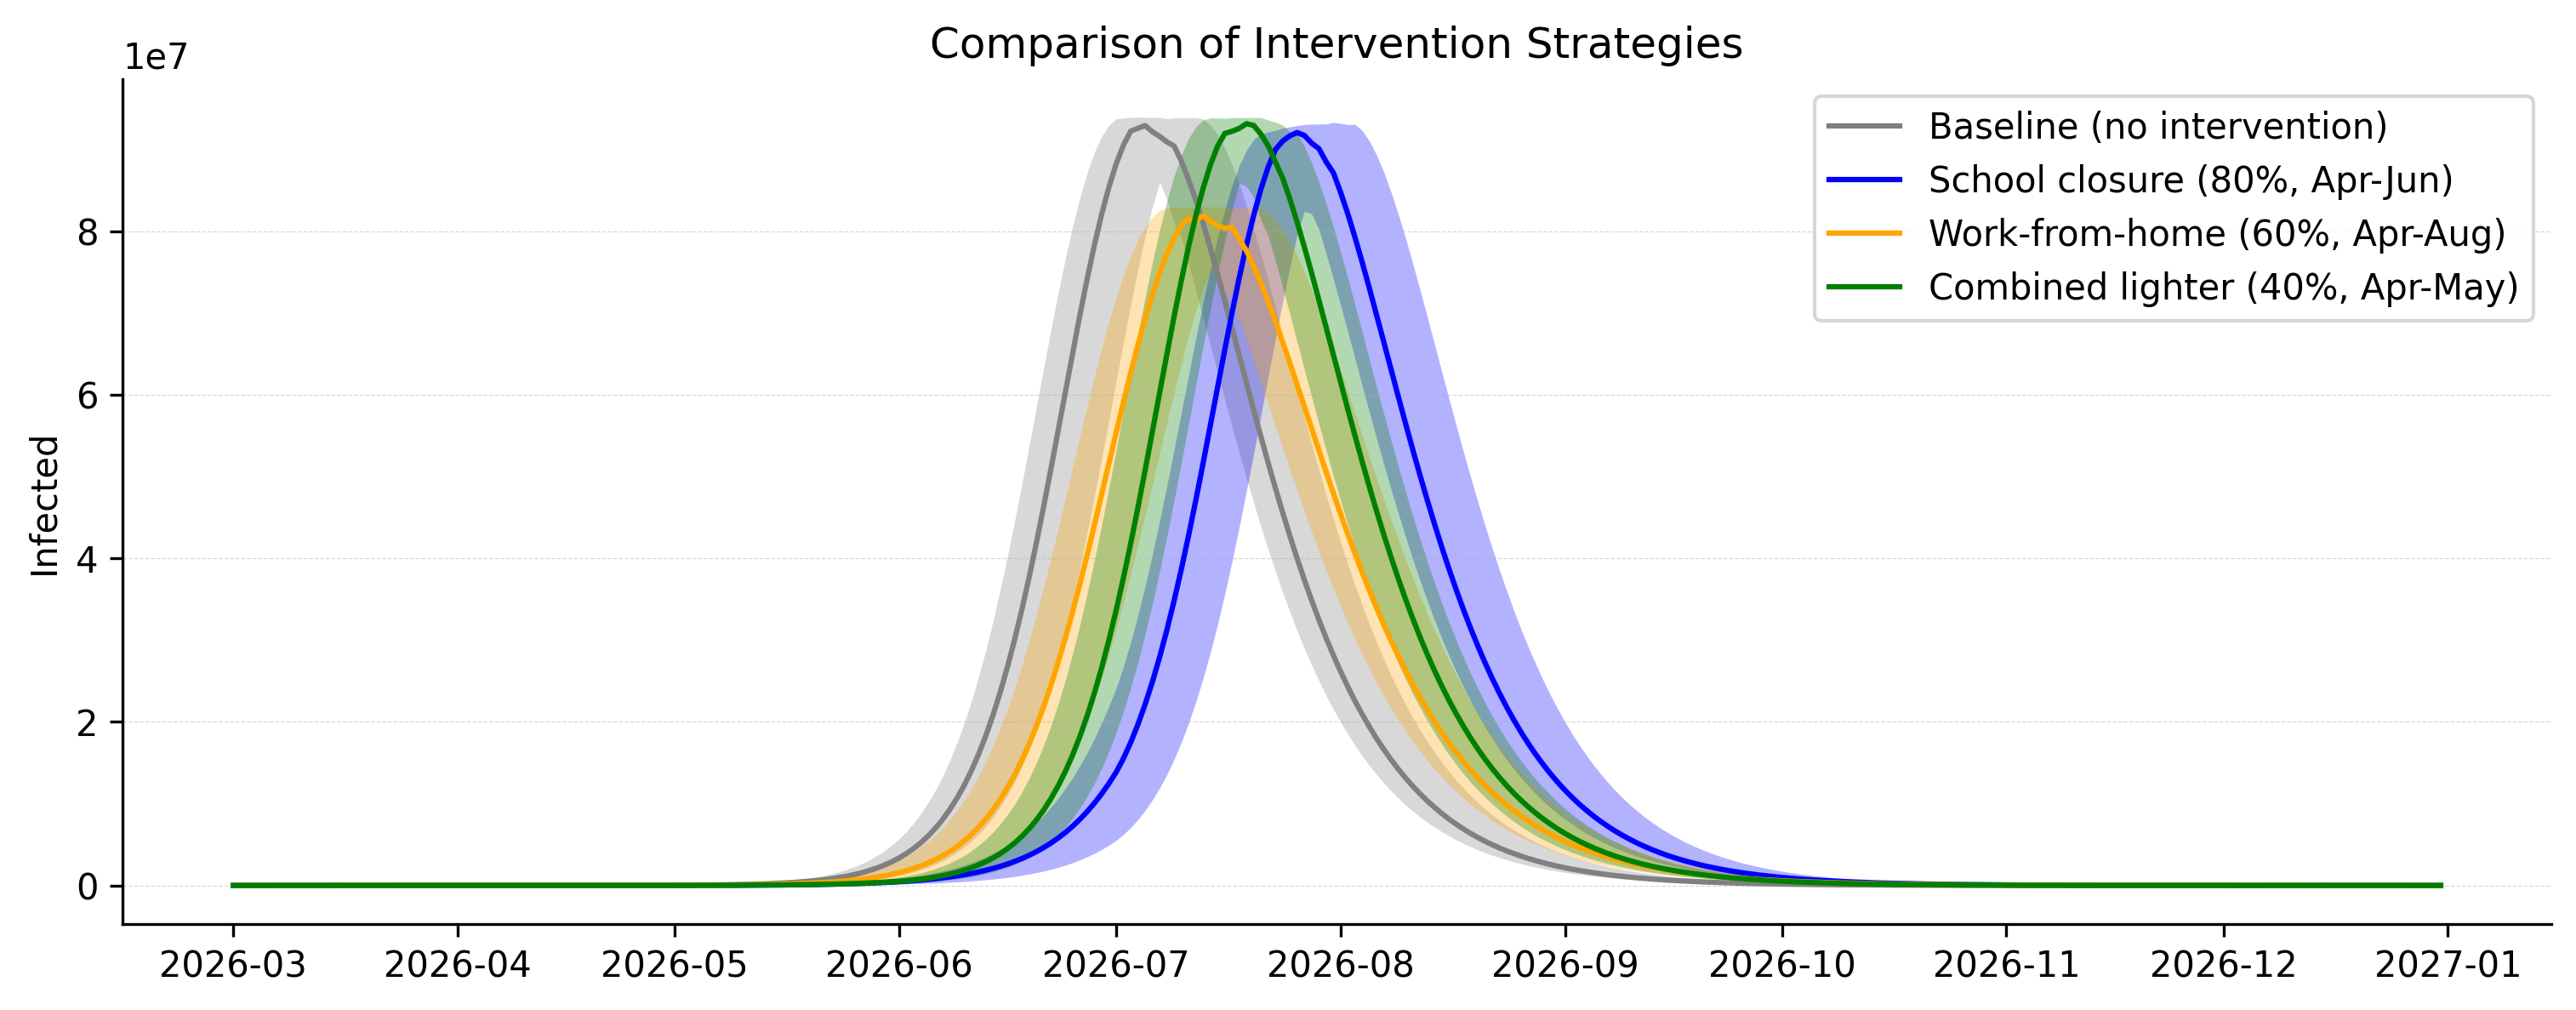

In [25]:
%%R
# Get quantiles for each scenario
df_baseline <- results_baseline$get_quantiles_compartments()
df_school <- results_school$get_quantiles_compartments()
df_work <- results_work$get_quantiles_compartments()
df_combined <- results_combined$get_quantiles_compartments()

# Plot comparison
ax <- plot_quantiles(df_baseline, columns = c("I_total"),
                     colors = "gray", labels = "Baseline (no intervention)")
ax <- plot_quantiles(df_school, columns = c("I_total"),
                     colors = "blue", labels = "School closure (80%, Apr-Jun)", ax = ax)
ax <- plot_quantiles(df_work, columns = c("I_total"),
                     colors = "orange", labels = "Work-from-home (60%, Apr-Aug)", ax = ax)
ax <- plot_quantiles(df_combined, columns = c("I_total"),
                     colors = "green", labels = "Combined lighter (40%, Apr-May)", ax = ax)

ax$set_title("Comparison of Intervention Strategies")
ax$set_ylabel("Infected")
ax$legend(loc = "upper right")
ax

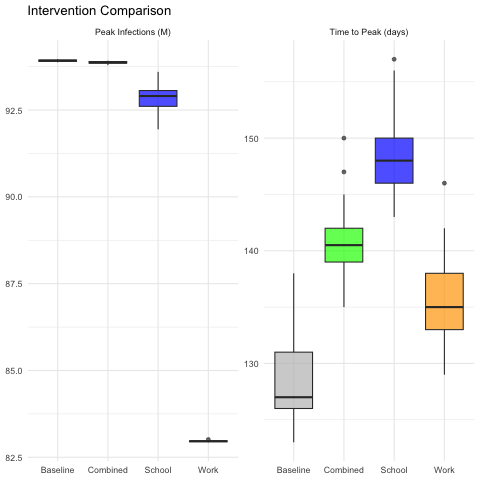

In [27]:
%%R
library(ggplot2)
library(tibble)

# Build data frame for boxplot comparison
df_metrics <- tibble(
  metric = c(
    rep("Peak Infections (M)", 4 * length(metrics_baseline$peak)),
    rep("Time to Peak (days)", 4 * length(metrics_baseline$time_to_peak))
  ),
  scenario = c(
    rep("Baseline", length(metrics_baseline$peak)),
    rep("School", length(metrics_school$peak)),
    rep("Work", length(metrics_work$peak)),
    rep("Combined", length(metrics_combined$peak)),
    rep("Baseline", length(metrics_baseline$time_to_peak)),
    rep("School", length(metrics_school$time_to_peak)),
    rep("Work", length(metrics_work$time_to_peak)),
    rep("Combined", length(metrics_combined$time_to_peak))
  ),
  value = c(
    metrics_baseline$peak/1e6, metrics_school$peak/1e6,
    metrics_work$peak/1e6, metrics_combined$peak/1e6,
    metrics_baseline$time_to_peak, metrics_school$time_to_peak,
    metrics_work$time_to_peak, metrics_combined$time_to_peak
  )
)

ggplot(df_metrics, aes(x = scenario, y = value, fill = scenario)) +
  geom_boxplot(alpha = 0.7, show.legend = FALSE) +
  facet_wrap(~metric, scales = "free_y") +
  labs(x = NULL, y = NULL, title = "Intervention Comparison") +
  theme_minimal() +
  scale_fill_manual(values = c("Baseline" = "gray", "School" = "blue",
                               "Work" = "orange", "Combined" = "green"))

## Discussion

**Which strategy is most effective?**

1. **Work-from-home (60%, Apr-Aug)** typically shows the best performance because working adults have the highest contact rates and the longer duration provides sustained protection.

2. **School closure (80%, Apr-Jun)** is intense but shorter, with limited impact on adult-to-adult transmission.

3. **Combined lighter (40%, Apr-May)** affects multiple routes but the shortest duration limits overall impact.

**Key trade-offs:**

| Factor | School Closure | Work-from-Home | Combined Lighter |
|--------|---------------|----------------|------------------|
| Economic impact | Lower | Higher | Moderate |
| Sustainability | Short-term only | More sustainable | Most sustainable |
| Effectiveness | Age-targeted | Broad | Moderate |